# Generate data from GO Bench website

Go to the GO Bench dataset form to access a form for requesting datasets. 

<img src="images/gb_header.png" width=800>

Select dataset parameters such as acceptable evidence codes, annotation propagation, or namespace, on the GO_Bench dataset_form page. Presets are highly recommended, but for details of code see documentation page. 

<img src="images/gb_presets_ex.png" width=400>

On submission, the form will lead to a loading page, where your download will become available. Download for access to annotations. 

<img src="images/gb_download_link_ex.png" width=400>


# Data extraction

Uncompress data using `tar -xzvf GO_benchmark_data.tar.gz` and move results to the data directory. You should find the following file structure, containing tsv files with protein identifiers and annotations, and the sets of GO terms found in files for each namespace. 

<img src="images/gb_file_structure.png" width=400>




In [2]:
!mkdir data/GO_benchmark_data
!tar -xzvf data/GO_benchmark_data.tar.gz -C data/GO_benchmark_data
!pip install git+https://github.com/amdson/go_bench.git
!pip install qtlsearch


mkdir: cannot create directory ‘data/GO_benchmark_data2’: File exists
tar: Removing leading `/' from member names
/
biological_process_terms.json
cellular_component_terms.json
molecular_function_terms.json
testing_biological_process_annotations.tsv
testing_cellular_component_annotations.tsv
testing_molecular_function_annotations.tsv
training_biological_process_annotations.tsv
training_cellular_component_annotations.tsv
training_molecular_function_annotations.tsv
validation_biological_process_annotations.tsv
validation_cellular_component_annotations.tsv
validation_molecular_function_annotations.tsv


# Download sequences

Protein sequences from the SwissProt dataset used in GO Bench are linked to in the Supplementary page on GO Bench, and can again be extracted using `tar -xvzf ...` 

The resulting compressed fasta file should be saved for use in model predictions. 

<img src="images/gb_swiss_dl_link.png" width=400>

Because of the large file size, protein sequences must be downloaded seperately. 



In [3]:
!wget https://ftp.uniprot.org/pub/databases/uniprot/previous_major_releases/release-2021_02/knowledgebase/uniprot_sprot-only2021_02.tar.gz
!tar -xvzf uniprot_sprot-only2021_02.tar.gz -C data

--2021-12-27 01:40:41--  https://ftp.uniprot.org/pub/databases/uniprot/previous_major_releases/release-2021_02/knowledgebase/uniprot_sprot-only2021_02.tar.gz
Resolving ftp.uniprot.org (ftp.uniprot.org)... 128.175.240.195
Connecting to ftp.uniprot.org (ftp.uniprot.org)|128.175.240.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1491395408 (1.4G) [application/x-gzip]
Saving to: ‘uniprot_sprot-only2021_02.tar.gz’

uniprot_sprot-only2 100%[===================>]   1.39G  34.3MB/s    in 71s     

2021-12-27 01:41:52 (20.1 MB/s) - ‘uniprot_sprot-only2021_02.tar.gz’ saved [1491395408/1491395408]



# go_bench for data loading

In [1]:
%load_ext autoreload
%autoreload 2
from go_bench.load_tools import load_protein_sequences, load_GO_tsv_file, convert_to_sparse_matrix
import json

In [6]:
dtypes = ["training", "validation", "testing"]
namespace = "molecular_function"
with open(f"data/GO_benchmark_data/{namespace}_terms.json", "r") as f:
    term_list = json.load(f)
    
dsets = []
for dtype in dtypes:
    protein_annotation_dict = load_GO_tsv_file(f"data/GO_benchmark_data/{dtype}_{namespace}_annotations.tsv")
    prot_id_whitelist = [prot_id for prot_id in protein_annotation_dict.keys()]
    sequences, prot_ids = load_protein_sequences("data/uniprot_sprot.fasta.gz", prot_id_whitelist)
    labels = convert_to_sparse_matrix(protein_annotation_dict, term_list, prot_ids)
    dsets.append((prot_ids, sequences, labels))

training_ids, training_sequences, training_labels = dsets[0]
validation_ids, validation_sequences, validation_labels = dsets[1]
testing_ids, testing_sequences, testing_labels = dsets[2]

print(training_sequences[:3])
print(len(training_ids), len(validation_ids), len(testing_ids))

['mstilekisaiesemartqknkatsahlgllkaklaklrrelispkgggggtgeagfevaktgdarvgfvgfpsvgkstllsnlagvysevaayefttlttvpgcikykgakiqlldlpgiiegakdgkgrgrqviavartcnlifmvldclkplghkkllehelegfgirlnkkppniyykrkdkgginlnsmvpqseldtdlvktilseykihnaditlrydatsddlidviegnriyipciyllnkidqisieeldviykiphcvpisahhhwnfddllelmweylrlqriytkpkgqlpdynspvvlhnertsiedfcnklhrsiakefkyalvwgssvkhqpqkvgiehvlndedvvqivkkv', 'menerekqvylaklseqterydemveamkkvaqldveltveernlvsvgyknvigarraswrilssieqkeeskgndenvkrlknyrkrvedelakvcndilsvidkhlipssnavestvffykmkgdyyrylaefssgaerkeaadqsleaykaavaaaenglapthpvrlglalnfsvfyyeilnspesacqlakqafddaiaeldslneesykdstlimqllrdnltlwtsdlneegdertkgadepqden', 'matpgassardefvymaklaeqaeryeemvefmekvakavdkdeltveernllsvayknvigarraswriissieqkeesrgnddhvslirdyrskietelsdicdgilklldtilvpaaasgdskvfylkmkgdyhrylaefksgqerkdaaehtltaykaaqdianselapthpirlglalnfsvfyyeilnspdracnlakqafdeaiaeldtlgeesykdstlimqllrdnltlwtsdmqddvaddikeaapaaakpadeqqs']
34192 7496 8753


# Simple modeling with knn

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1,2))
vectorizer.fit(training_sequences)
print(len(vectorizer.get_feature_names()))
X_training = vectorizer.transform(training_sequences)
X_testing = vectorizer.transform(testing_sequences)
print(X_training.shape)
print(X_testing.shape)
y_training = training_labels
y_testing = testing_labels
print(y_training.shape)
print(y_testing.shape)

(34192, 489)
(8753, 489)
(34192, 659)
(8753, 659)


In [14]:
from skmultilearn.adapt import MLkNN
knn = MLkNN(k=5)
knn.fit(X_training, y_training)
predictions = knn.predict(X_testing)

In [24]:
prediction_probs = knn.predict_proba(X_testing)

In [25]:
print(predictions.shape)
prediction_probs = 
print(prediction_probs.shape)

(8753, 659)
(8753, 659)


# Evaluate predictions with go_bench

In [36]:
from go_bench.metrics import threshold_stats
import numpy as np
from qtlsearch.OBOParser import OBO
from go_bench.load_tools import write_sparse

go = OBO('data/go-basic.obo', store_as_int=True)

with open("data/ia_dict.json", "r") as f:
    ia_dict = {int(x): float(y) for x, y in json.load(f).items()}

test_ia = np.zeros(len(term_list))
for i, test_id in enumerate(term_list):
    id_int = int(test_id[3:])
    if(id_int in go and id_int in ia_dict):
        test_ia[i] = ia_dict[id_int]
        
prediction_probs = knn.predict_proba(X_testing)

from scipy.sparse import csr_matrix
prediction_probs = csr_matrix(prediction_probs)

precs, recs, f_scores, rms, mis, rus, s_vals = threshold_stats(csr_matrix(y_testing), prediction_probs, test_ia)

In [40]:
with open("data/ia_dict.json", "r") as f:
    ia_dict = {int(x): float(y) for x, y in json.load(f).items()}

test_ia = np.zeros(len(term_list))
for i, test_id in enumerate(term_list):
    id_int = int(test_id[3:])
    if(id_int in go and id_int in ia_dict):
        test_ia[i] = ia_dict[id_int]

In [48]:
from scipy.sparse import csr_matrix
prediction_probs = csr_matrix(prediction_probs)

precs, recs, f_scores, rms, mis, rus, s_vals = threshold_stats(csr_matrix(y_testing), prediction_probs, test_ia)

/home/andrew/anaconda3/envs/research/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrew/research/gene_ontology_ML/go_bench/src/go_bench/metrics.py:34: RuntimeWarning: invalid value encountered in double_scalars
  s_vals.append(s)


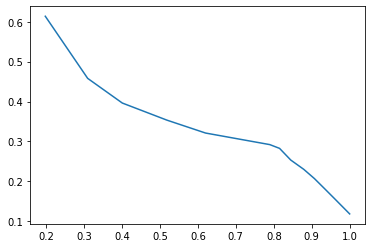

0.426277660046326


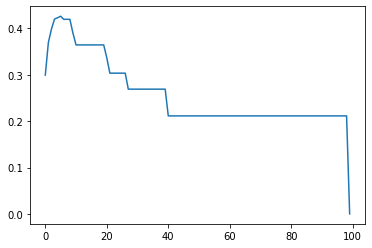

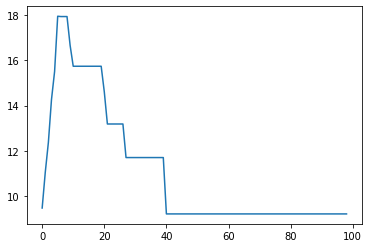

In [60]:
import matplotlib.pyplot as plt
plt.plot(precs[:-1], recs[:-1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.show()
plt.plot(f_scores)
print(max(f_scores))
plt.show()
plt.plot(rms)
plt.show()

# Save predictions for submission

In [55]:
write_sparse(f'data/molecular_function_predictions.tsv', prediction_probs, testing_ids, term_list, go, 0.01)

# Submit predictions

Submit predictions in the CAFA format (As produced by the write_sparse function) to the GO Bench website to compare with other teams, and see evaluations. 

<img src="images/gb_upload_screen.png" width=550>

After submission, you can view your model on our leaderboard, or visualize its results using the model visualizations tool on the sideboard. 

<img src="images/model_viz_page.png" width=600>
